# Récupération des données météorologiques

In [21]:
import requests
import json
import pandas as pd

In [22]:


def load_meteo( start_date="2024-11-30", end_date="2025-12-01"):
    """Charge les données météo historiques depuis Open-Meteo ERA5
 """
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude=43.6109&longitude=3.8763"
        f"&start_date={start_date}&end_date={end_date}"
        f"&hourly=temperature_2m,wind_speed_10m,precipitation"
        )
    
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur API : {response.status_code}")
        return None

    data = response.json()
    
    return data

data_json= load_meteo()
print(data_json)

{'latitude': 43.620384, 'longitude': 3.930723, 'generationtime_ms': 4.021048545837402, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 58.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'wind_speed_10m': 'km/h', 'precipitation': 'mm'}, 'hourly': {'time': ['2024-11-30T00:00', '2024-11-30T01:00', '2024-11-30T02:00', '2024-11-30T03:00', '2024-11-30T04:00', '2024-11-30T05:00', '2024-11-30T06:00', '2024-11-30T07:00', '2024-11-30T08:00', '2024-11-30T09:00', '2024-11-30T10:00', '2024-11-30T11:00', '2024-11-30T12:00', '2024-11-30T13:00', '2024-11-30T14:00', '2024-11-30T15:00', '2024-11-30T16:00', '2024-11-30T17:00', '2024-11-30T18:00', '2024-11-30T19:00', '2024-11-30T20:00', '2024-11-30T21:00', '2024-11-30T22:00', '2024-11-30T23:00', '2024-12-01T00:00', '2024-12-01T01:00', '2024-12-01T02:00', '2024-12-01T03:00', '2024-12-01T04:00', '2024-12-01T05:00', '2024-12-01T06:00', '2024-12-01T07:00', '2024-12-01T08:00', '2024-12-01T09:00', '2024-12

In [23]:

def process_weather_data(json_data):
    """
    Extrait uniquement les données horaires et crée une série temporelle propre.
    """
    # 1. Extraction Ciblée
    # On plonge directement dans la clé 'hourly'. On ignore le reste pour l'instant.
    hourly_data = json_data['hourly']
    
    # 2. Création du DataFrame
    # Comme hourly_data est un dictionnaire de listes de même longueur, 
    # Pandas va créer les colonnes parfaitement.
    df = pd.DataFrame(hourly_data)

    # 3. Renommage de la colonne
    # 'columns' spécifie les changements, 'inplace=True' applique la modification directement au DataFrame
    df.rename(columns={'time':'datetime'}, inplace=True)
    print(f"Colonne '{'time'}' renommée en '{'datetime'}' avec succès.")

    # 3. Nettoyage (Typage et Index)
    # Conversion du texte en vraies dates
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # On met le temps en index (axe des lignes)
    df = df.set_index('datetime')
    
    return df

# --- Exécution ---
df_clean = process_weather_data(data_json)

print("--- DataFrame Propre ---")
print(df_clean)
print("\n--- Types des colonnes ---")
print(df_clean.dtypes)


Colonne 'time' renommée en 'datetime' avec succès.
--- DataFrame Propre ---
                     temperature_2m  wind_speed_10m  precipitation
datetime                                                          
2024-11-30 00:00:00             5.8             7.9            0.0
2024-11-30 01:00:00             5.2             8.7            0.0
2024-11-30 02:00:00             5.0             9.0            0.0
2024-11-30 03:00:00             5.0             8.9            0.0
2024-11-30 04:00:00             4.8             8.3            0.0
...                             ...             ...            ...
2025-12-01 19:00:00             4.8             5.4            0.0
2025-12-01 20:00:00             4.3             6.1            0.0
2025-12-01 21:00:00             3.9             6.5            0.0
2025-12-01 22:00:00             4.3             7.2            0.0
2025-12-01 23:00:00             3.8             8.2            0.0

[8808 rows x 3 columns]

--- Types des colonnes ---


# Vérification des données : données manquantes, aberantes, null

In [24]:
import pandas as pd
import numpy as np

def audit_dataframe(df):
    """
    Réalise un audit complet de la qualité des données :
    - Valeurs manquantes
    - Doublons
    - Détection d'outliers (méthode IQR)
    """
    print(f" --- AUDIT DU DATAFRAME ({df.shape[0]} lignes, {df.shape[1]} colonnes) ---")
    
    # 1. Vérification des types
    print("\n Types des données :")
    print(df.dtypes)

    # 2. Valeurs Manquantes
    print("\n Valeurs Manquantes (NaN) :")
    missing = df.isnull().sum()
    missing = missing[missing > 0] # On n'affiche que ceux qui ont des problèmes
    if missing.empty:
        print(" Aucune valeur manquante détectée.")
    else:
        print(missing)
        # Pourcentage de vide
        # On fait la moyenne des colonnes, PUIS la moyenne du résultat global
        print(f"   -> Globalement : {df.isnull().mean().mean():.2%} du tableau est vide.")

    # 3. Doublons
    duplicates = df.duplicated().sum()
    print(f"\n Lignes Dupliquées : {duplicates}")

    # 4. Détection des Outliers (Méthode IQR)
    # On ne travaille que sur les colonnes numériques
    # select_dtypes agit comme un tamis. On lui dit : "Garde uniquement les colonnes qui contiennent des nombres (np.number c'est-à-dire int ou float)."
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    print("\n Détection d'Outliers Potentiels (Méthode IQR) :")
    for col in numeric_cols:
        # Calcul des Quartiles
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Bornes (Tout ce qui est en dehors est considéré comme outlier)
        # Pourquoi 1.5 ? C'est une convention statistique (règle de Tukey). On prend la largeur du "ventre mou" (IQR) et on l'étend d'une fois et demie vers le haut et vers le bas.
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Compter les outliers
        # Compte toutes les lignes qui sont SOIT trop petites, SOIT trop grandes.
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"Outlier de la colonne {df[col]}, min: {(df[col] < lower_bound)}, max: {(df[col] > upper_bound)}  ")
        if outliers_count > 0:
            print(f"    Colonne '{col}' : {outliers_count} outliers détectés")
            print(f"    (Bornes acceptables : {lower_bound:.2f} à {upper_bound:.2f})")
        else:
            print(f"    Colonne '{col}' : Clean")



audit_dataframe(df_clean)

 --- AUDIT DU DATAFRAME (8808 lignes, 3 colonnes) ---

 Types des données :
temperature_2m    float64
wind_speed_10m    float64
precipitation     float64
dtype: object

 Valeurs Manquantes (NaN) :
 Aucune valeur manquante détectée.

 Lignes Dupliquées : 515

 Détection d'Outliers Potentiels (Méthode IQR) :
Outlier de la colonne datetime
2024-11-30 00:00:00    5.8
2024-11-30 01:00:00    5.2
2024-11-30 02:00:00    5.0
2024-11-30 03:00:00    5.0
2024-11-30 04:00:00    4.8
                      ... 
2025-12-01 19:00:00    4.8
2025-12-01 20:00:00    4.3
2025-12-01 21:00:00    3.9
2025-12-01 22:00:00    4.3
2025-12-01 23:00:00    3.8
Name: temperature_2m, Length: 8808, dtype: float64, min: datetime
2024-11-30 00:00:00    False
2024-11-30 01:00:00    False
2024-11-30 02:00:00    False
2024-11-30 03:00:00    False
2024-11-30 04:00:00    False
                       ...  
2025-12-01 19:00:00    False
2025-12-01 20:00:00    False
2025-12-01 21:00:00    False
2025-12-01 22:00:00    False
2025-12-

In [32]:
import pandas as pd

def exporter_donnees(df, nom_fichier="data/meteo_clean.csv"):
    print(f" Sauvegarde en cours vers '{nom_fichier}'...")
    
    # --- Option 1 : La version Standard (US/International) ---
    # Parfait si tu réutilises ce fichier en Python plus tard
    # df.to_csv(nom_fichier) 
    
    # --- Option 2 : La version "Excel Français" (Recommandée) ---
    # Pour être sûr que les accents passent et que les colonnes soient bien séparées
    df.to_csv(
        nom_fichier,
        sep=',',             # On utilise le point-virgule (standard Excel FR)
        decimal=',',         # On utilise la virgule pour les décimales (ex: 20,5 au lieu de 20.5)
        encoding='utf-8-sig',# 'utf-8-sig' force Excel à bien lire les accents (é, à, è)
        index=True           # CRUCIAL : On garde l'index (tes dates !)
    )
    
    print("Export réussi !")

# --- Exécution ---
# Assure-toi d'utiliser ton dataframe nettoyé
exporter_donnees(df_clean, )
# print(df_clean['temperature_2m'])


 Sauvegarde en cours vers 'data/meteo_clean.csv'...


OSError: Cannot save file into a non-existent directory: 'data'

In [26]:
!pip install seaborn
!pip install matplotlib


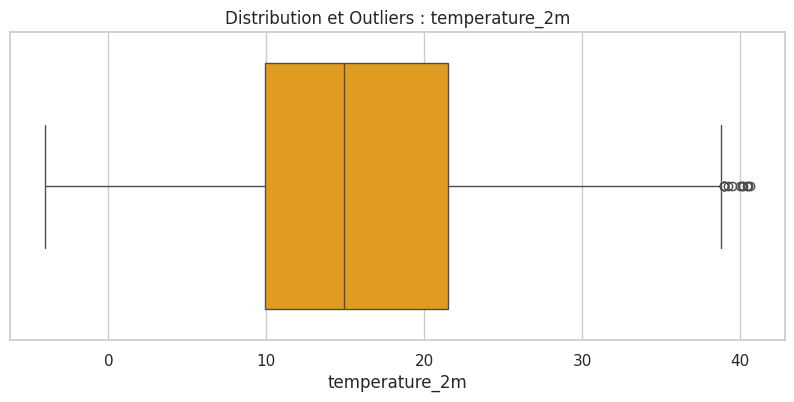

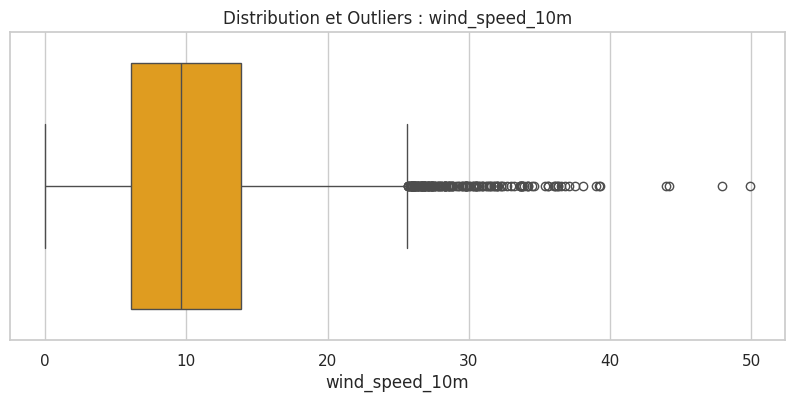

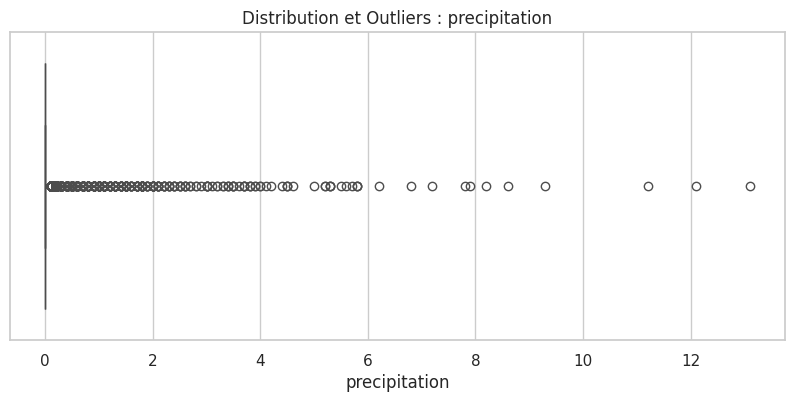

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_outliers(df, column):
    plt.figure(figsize=(10, 4))
    
    # Création du Boxplot
    sns.boxplot(x=df[column], color='orange')
    
    plt.title(f"Distribution et Outliers : {column}")
    plt.show()

# Testons sur la température
visualize_outliers(df_clean, 'temperature_2m')
visualize_outliers(df_clean, 'wind_speed_10m')
visualize_outliers(df_clean, 'precipitation')



# Cibler les outliers
Les valeurs des outliers ne sont pas extrêmes pour les définir comme des valeusr aberrantes

**Records Absolus & Tendances**

In [28]:
import pandas as pd

def extract_weather_events(df):
    print(" --- EXTRACTION DES ÉVÉNEMENTS MÉTÉO ---")
    
    # --- A. PRÉPARATION ---
    # On crée des colonnes lisibles pour l'affichage (Jour, Mois, Heure)
    # L'accesseur .dt est magique pour extraire des infos de l'index temporel
    df_view = df.copy()
    df_view['Mois'] = df.index.month_name()
    df_view['Heure'] = df.index.hour
    df_view['Date'] = df.index.date
    
    # --- B. DÉFINITION DES SEUILS ---
    mean_temp = df['temperature_2m'].mean()
    # Pour "les plus basses", on prend le "décile" le plus bas (les 10% les plus froids)
    cold_threshold = df['temperature_2m'].quantile(0.10)
    # Pour "venteux", on considère le top 20% des vents les plus forts
    windy_threshold = df['wind_speed_10m'].quantile(0.80)
    
    print(f" Moyenne Temp: {mean_temp:.2f}°C | Seuil Froid (<10%): {cold_threshold:.2f}°C | Seuil Vent (>80%): {windy_threshold:.2f} km/h")

    # --- C. DÉFINITION DES MASQUES (LES CONDITIONS) ---
    conditions = {
        " Température Au-dessus de la moyenne": df['temperature_2m'] > mean_temp,
        
        " Températures les plus basses (Top 10% froid)": df['temperature_2m'] <= cold_threshold,
        
        " Moment où il pleut/neige": (df['precipitation'] > 0),
        
        " Venteux (Fort vent)": df['wind_speed_10m'] > windy_threshold,
        
        " Calme plat (Pas ou peu de vent)": df['wind_speed_10m'] < 2.0  # Moins de 2 km/h
    }

    # --- D. AFFICHAGE DES RÉSULTATS ---
    for title, mask in conditions.items():
        # On applique le masque : df[mask] ne garde que les lignes Vraies
        subset = df_view.loc[mask]
        
        print(f"\n{'='*50}")
        print(f"{title}")
        print(f"{'='*50}")
        
        if subset.empty:
            print("Aucun événement trouvé pour cette condition.")
        else:
            print(f"Nombre d'heures concernées : {len(subset)}")
            
            # Affichage des 5 premiers exemples
            cols_to_show = ['Date', 'Heure', 'Mois', 'temperature_2m', 'wind_speed_10m', 'precipitation']
            print("Exemple des premières occurrences :")
            print(subset[cols_to_show].head(5))
            
            # Analyse Rapide : Quels mois sont les plus touchés par ce phénomène ?
            top_months = subset['Mois'].value_counts().head(3)
            print(f"\n📅 Mois les plus fréquents pour ce phénomène : {top_months.to_dict()}")

# --- Exécution ---
extract_weather_events(df_clean)

 --- EXTRACTION DES ÉVÉNEMENTS MÉTÉO ---
 Moyenne Temp: 15.78°C | Seuil Froid (<10%): 5.80°C | Seuil Vent (>80%): 15.00 km/h

 Température Au-dessus de la moyenne
Nombre d'heures concernées : 4120
Exemple des premières occurrences :
                           Date  Heure      Mois  temperature_2m  \
datetime                                                           
2024-12-02 15:00:00  2024-12-02     15  December            16.1   
2024-12-06 10:00:00  2024-12-06     10  December            15.9   
2024-12-06 11:00:00  2024-12-06     11  December            16.8   
2024-12-06 12:00:00  2024-12-06     12  December            16.9   
2024-12-06 13:00:00  2024-12-06     13  December            17.8   

                     wind_speed_10m  precipitation  
datetime                                            
2024-12-02 15:00:00            11.3            0.0  
2024-12-06 10:00:00            19.8            0.0  
2024-12-06 11:00:00            23.2            0.0  
2024-12-06 12:00:00      

 --- GÉNÉRATION DU GRAPHIQUE DES ÉVÉNEMENTS ---

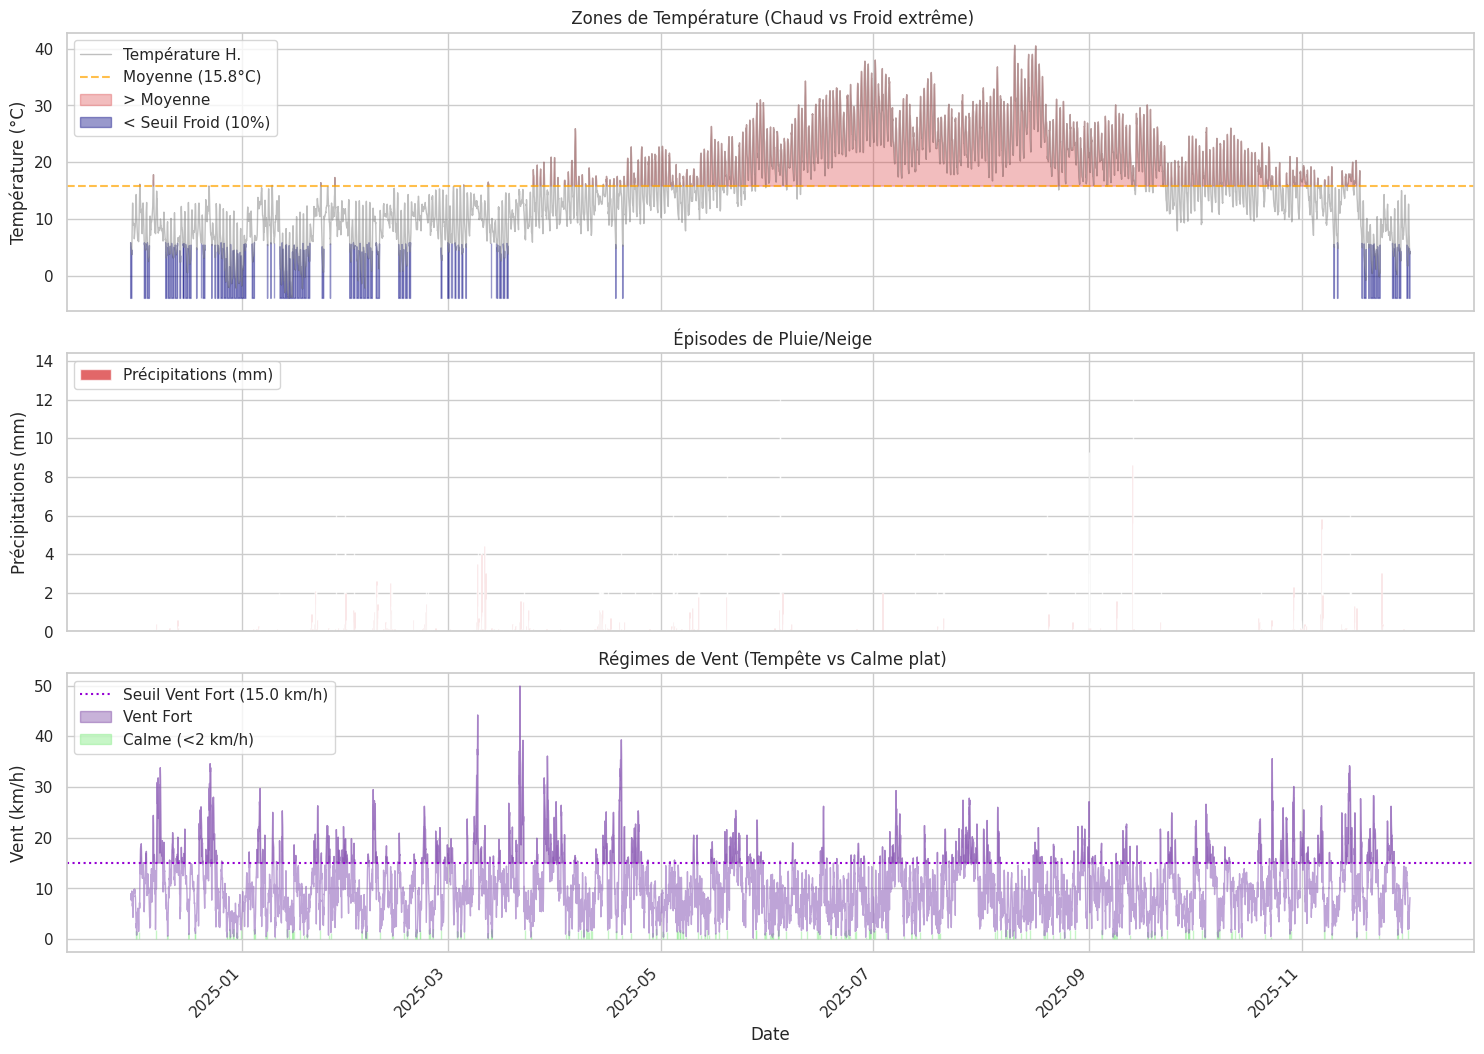

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# On définit le style pour que ce soit joli par défaut
sns.set_theme(style="whitegrid")

def visualize_weather_events(df):
    print(" --- GÉNÉRATION DU GRAPHIQUE DES ÉVÉNEMENTS ---")
    
    # --- 1. Calcul des seuils (les mêmes que précédemment) ---
    mean_temp = df['temperature_2m'].mean()
    cold_threshold = df['temperature_2m'].quantile(0.10)
    windy_threshold = df['wind_speed_10m'].quantile(0.80)
    calm_threshold = 2.0

    # --- 2. Création de la structure (3 graphiques superposés) ---
    # figsize=(largeur, hauteur) -> On fait un graphique haut
    # sharex=True est CRUCIAL : permet de zoomer sur les 3 graphiques en même temps
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

    # =================================================================
    # GRAPHIQUE 1 : TEMPÉRATURE (Zones Chaudes/Froides)
    # =================================================================
    # La courbe de base
    ax1.plot(df.index, df['temperature_2m'], color='grey', alpha=0.5, linewidth=1, label='Température H.')
    # La ligne moyenne
    ax1.axhline(y=mean_temp, color='orange', linestyle='--', alpha=0.7, label=f'Moyenne ({mean_temp:.1f}°C)')

    # --> LE SURLIGNAGE (fill_between) <--
    # Zone Chaude (Au-dessus de la moyenne) : Remplir en rouge pâle
    ax1.fill_between(df.index, df['temperature_2m'], mean_temp, 
                     where=(df['temperature_2m'] > mean_temp),
                     interpolate=True, color='tab:red', alpha=0.3, label='> Moyenne')
    
    # Zone Froide (Top 10% froid) : Remplir en bleu glacial
    # On remplit entre la courbe et le bas du graphique pour bien marquer le froid
    ax1.fill_between(df.index, df['temperature_2m'], df['temperature_2m'].min(),
                     where=(df['temperature_2m'] <= cold_threshold),
                     interpolate=True, color='navy', alpha=0.4, label='< Seuil Froid (10%)')

    ax1.set_ylabel('Température (°C)')
    ax1.set_title(" Zones de Température (Chaud vs Froid extrême)")
    ax1.legend(loc='upper left', frameon=True)

    # =================================================================
    # GRAPHIQUE 2 : PRÉCIPITATIONS (Pluie/Neige)
    # =================================================================
    # Pour la pluie, un "Bar plot" est plus adapté qu'une ligne, car c'est discontinu.
    # On utilise 'precipitation' qui combine pluie et neige
    ax2.bar(df.index, df['precipitation'], color='tab:red', alpha=0.7, width=0.04, label='Précipitations (mm)')
    
    ax2.set_ylabel('Précipitations (mm)')
    ax2.set_title(" Épisodes de Pluie/Neige")
    # On limite l'axe Y pour ne pas écraser les petites pluies s'il y a un orage énorme
    # On met le max à un niveau raisonnable (ex: le quantile 99.5% ou une valeur fixe)
    ymax_rain = df['precipitation'].max()
    if ymax_rain > 0: 
        ax2.set_ylim(0, ymax_rain * 1.1) # 10% de marge au dessus du max
    ax2.legend(loc='upper left')

    # =================================================================
    # GRAPHIQUE 3 : VENT (Fort vs Calme)
    # =================================================================
    # Courbe de base
    ax3.plot(df.index, df['wind_speed_10m'], color='tab:purple', alpha=0.6, linewidth=1)
    
    # Seuil de vent fort
    ax3.axhline(y=windy_threshold, color='darkviolet', linestyle=':', label=f'Seuil Vent Fort ({windy_threshold:.1f} km/h)')

    # Surlignage Vent Fort (Violet)
    ax3.fill_between(df.index, df['wind_speed_10m'], windy_threshold,
                     where=(df['wind_speed_10m'] > windy_threshold),
                     interpolate=True, color='indigo', alpha=0.3, label='Vent Fort')

    # Surlignage Calme Plat (Vert pâle)
    ax3.fill_between(df.index, df['wind_speed_10m'], 0,
                     where=(df['wind_speed_10m'] < calm_threshold),
                     interpolate=True, color='lightgreen', alpha=0.5, label='Calme (<2 km/h)')

    ax3.set_ylabel('Vent (km/h)')
    ax3.set_xlabel('Date')
    ax3.set_title(" Régimes de Vent (Tempête vs Calme plat)")
    ax3.legend(loc='upper left')

    # --- Finalisation ---
    plt.tight_layout() # Ajuste les espacements pour éviter les chevauchements
    
    # Astuce pour formater les dates en bas si c'est trop chargé
    fig.autofmt_xdate(rotation=45)
    
    plt.show()

# --- Exécution ---
# Assure-toi que df_clean est bien ton DataFrame avec l'index temporel
visualize_weather_events(df_clean)

## Visualisation par période

La Méthode "Rapide" (Pandas pur)
Pandas possède une fonction magique subplots=True. Elle sépare automatiquement chaque colonne dans son propre graphique, mais ils partagent tous le même axe de temps (X). C'est idéal pour un diagnostic immédiat.

📈 --- VUE D'ENSEMBLE TEMPORELLE ---


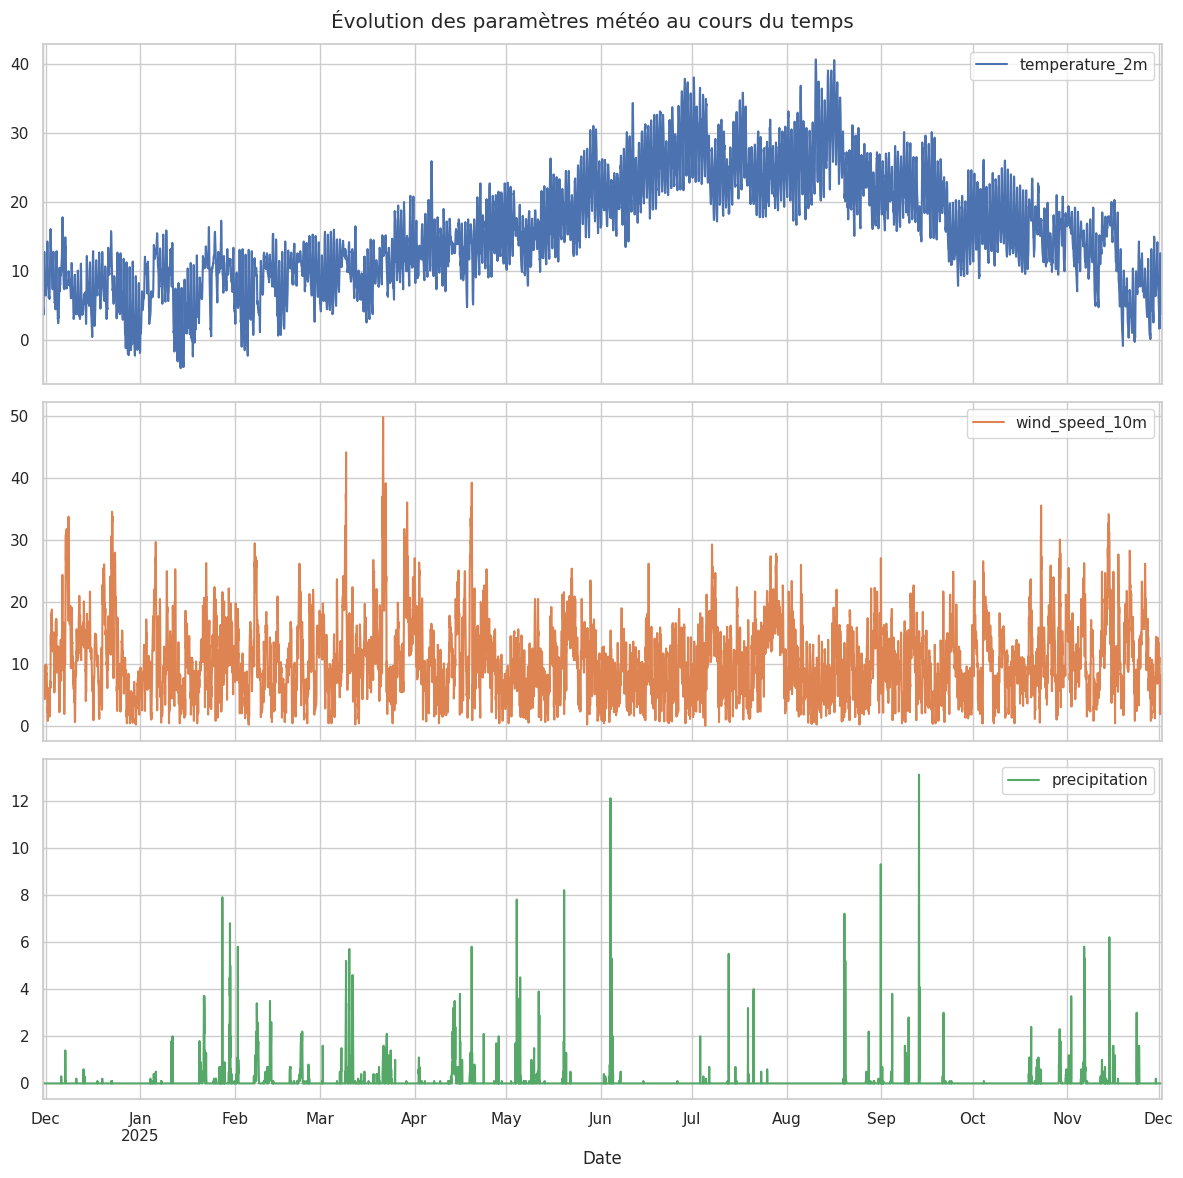

In [30]:
import matplotlib.pyplot as plt

def plot_quick_overview(df):
    """
    Affiche toutes les colonnes du DataFrame les unes sous les autres.
    """
    print("📈 --- VUE D'ENSEMBLE TEMPORELLE ---")
    
    # figsize=(largeur, hauteur_totale)
    # subplots=True : Créer un graph par colonne
    # sharex=True : Si tu zoomes sur un, les autres suivent (super pratique)
    df.plot(subplots=True, figsize=(12, 12), sharex=True, 
            title="Évolution des paramètres météo au cours du temps",
            grid=True)
    
    plt.xlabel("Date")
    plt.tight_layout() # Pour éviter que les titres se chevauchent
    plt.show()

# --- Exécution ---
# On sélectionne juste les colonnes intéressantes pour éviter d'afficher des trucs inutiles
cols_to_plot = ['temperature_2m', 'wind_speed_10m', 'precipitation']
plot_quick_overview(df_clean[cols_to_plot])

🔭 --- GÉNÉRATION DES VUES MULTI-RÉSOLUTIONS ---


KeyError: 'rain'

/home/nabil_simplon/velomag_montpellier/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/nabil_simplon/velomag_montpellier/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


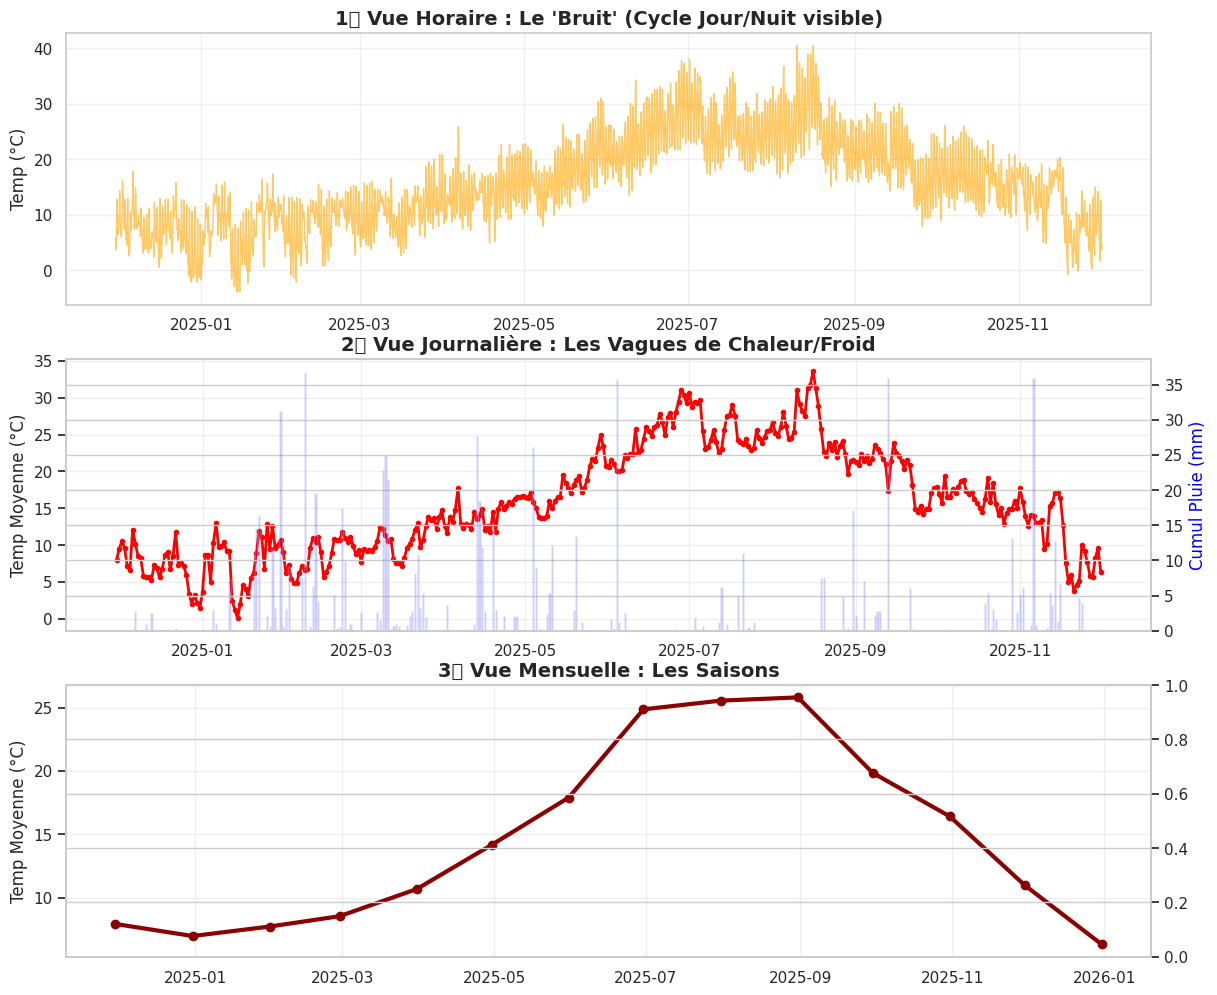

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multi_resolution(df):
    print("🔭 --- GÉNÉRATION DES VUES MULTI-RÉSOLUTIONS ---")
    
    # 1. PRÉPARATION DES DONNÉES (AGRÉGATION)
    # On définit comment résumer chaque colonne
    agg_rules = {
        'temperature_2m': 'mean',      # Moyenne pour la température
        'precipitation': 'sum',                 # Somme (cumul) pour la pluie
        'wind_speed_10m': 'mean'       # Moyenne pour le vent
    }
    
    # Création des DataFrames résumés
    df_hourly = df.copy() # Données brutes
    df_daily = df.resample('D').agg(agg_rules)   # Par Jour ('D')
    df_monthly = df.resample('ME').agg(agg_rules) # Par Mois ('ME' = Month End)

    # 2. VISUALISATION (3 Graphiques superposés)
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # --- VUE 1 : PAR HEURE (Le détail brut) ---
    axes[0].plot(df_hourly.index, df_hourly['temperature_2m'], color='orange', alpha=0.6, linewidth=1)
    axes[0].set_title("1️⃣ Vue Horaire : Le 'Bruit' (Cycle Jour/Nuit visible)", fontsize=14, fontweight='bold')
    axes[0].set_ylabel("Temp (°C)")
    axes[0].grid(True, alpha=0.3)

    # --- VUE 2 : PAR JOUR (La tendance court terme) ---
    # On marque les points (.) pour bien voir chaque jour
    axes[1].plot(df_daily.index, df_daily['temperature_2m'], color='red', marker='.', linestyle='-', linewidth=2)
    axes[1].set_title("2️⃣ Vue Journalière : Les Vagues de Chaleur/Froid", fontsize=14, fontweight='bold')
    axes[1].set_ylabel("Temp Moyenne (°C)")
    axes[1].grid(True, alpha=0.3)
    
    # Ajout de la pluie en arrière plan sur le graphique journalier
    ax1_rain = axes[1].twinx()
    ax1_rain.bar(df_daily.index, df_daily['precipitation'], color='blue', alpha=0.2)
    ax1_rain.set_ylabel("Cumul Pluie (mm)", color='blue')

    # --- VUE 3 : PAR MOIS (La saisonnalité) ---
    # Barres ou lignes épaisses
    axes[2].plot(df_monthly.index, df_monthly['temperature_2m'], color='darkred', marker='o', linewidth=3)
    axes[2].set_title("3️⃣ Vue Mensuelle : Les Saisons", fontsize=14, fontweight='bold')
    axes[2].set_ylabel("Temp Moyenne (°C)")
    axes[2].grid(True, alpha=0.3)
    
    # Ajout du cumul pluie mensuel
    ax2_rain = axes[2].twinx()
    ax2_rain.bar(df_monthly.index, df_monthly['rain'], color='navy', alpha=0.3, width=20) # width en jours approx
    ax2_rain.set_ylabel("Cumul Pluie (mm)", color='navy')

    plt.tight_layout()
    plt.show()

# --- Exécution ---
plot_multi_resolution(df_clean)

In [ ]:
!pip install nbformat